In [1]:
! nvidia-smi # bash command to controll the status of GPUs

Tue Sep 27 09:58:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 31%   54C    P0   112W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   

In [2]:
import os, random, xmltodict, json
import xml.etree.ElementTree as ET

cuda_device = 6 # which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]= str(cuda_device) # set which GPU device are visible

In [3]:
# "Basic" py library
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split 
from nltk.tokenize import word_tokenize

# Stats 
from mlxtend.evaluate import permutation_test

# visualisation
from matplotlib import pyplot as plt # basic visualisation in py
import seaborn as sns # great to interact with dataframes
import plotly.express as px # powerfull for interactive figures
from tqdm import tqdm  # generats progress bar to controll steps

# ML py
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import torch # Pytorch, Meta's library for ML
import torch.nn as nn # Pt module for neural networks 

import transformers # HuggingFace library to use pretrained models
from transformers import BertTokenizer, BertModel

In [4]:
def set_seed(seed: int):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)

In [5]:
# Set visual style of Seabonr
sns.set("talk")
sns.set_style("whitegrid")

#  set the random seed 
seed = 31
set_seed(seed)

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

[Distributions Visualisation](#visualisation)
 
[Clustering](#clstr)

## Loading data<a id='intro'></a>

In [6]:
dream_records = pd.read_csv(
    "Reports_DreamerEmotions_PCAxy_tSNExy.csv",
)

dream_records.sample(3)

,gender,age,type,collection,id,time,date,number,report,# words,Emotions,# Emotions,TSNE_x,TSNE_y,PCA_x,PCA_y
1506,M,Y,set,Hall/VdC Norms: Male,norms-m,1940s-1950s,Missing,0157,I walked out of the washroom at our country cl...,92,AP_SD,2,15.887519,-22.704357,-2.104239,-1.645522
933,F,Y,set,Hall/VdC Norms: Female,norms-f,1940s-1950s,Missing,0070,I had to take an exam in the psych lab. When I...,161,Missing,0,-6.198329,-25.068748,-0.621065,-1.351107
1820,M,Y,set,Hall/VdC Norms: Male,norms-m,1940s-1950s,Missing,0476,In this dream I received a letter from my girl...,136,AN_SD,2,3.489732,-4.147202,1.457005,-1.260987


In [7]:
# Load the dataset in CSV (already has BERT–Large emb. and PCA/t-SNE coordinates)
encodings_in_DF = False
with open('BERT-Large-Cased_dream_records.npy', 'rb') as f:
    T_encoding = np.load(f)
    
# del T_encoding 
if encodings_in_DF:
    dream_records["BERT-large-case-embeddings"] = list(T_encoding)

In [8]:
len(dream_records[dream_records["# words"] == 0])

0

## Distributions Visualisation<a id='visualisation'></a>
###### Commection distribution

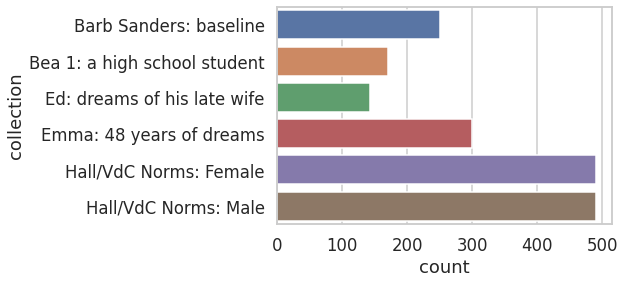

In [12]:
g = sns.countplot(
    data=dream_records, y="collection",
)
# g.tick_params(axis='x', rotation=45)

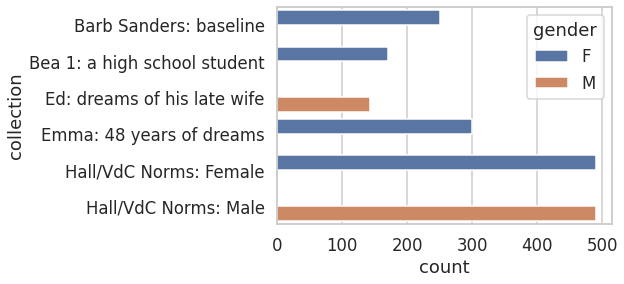

In [12]:
g = sns.countplot(
    data=dream_records, y="collection",
    hue="gender"
)
# g.tick_params(axis='x', rotation=45)

###### Collection

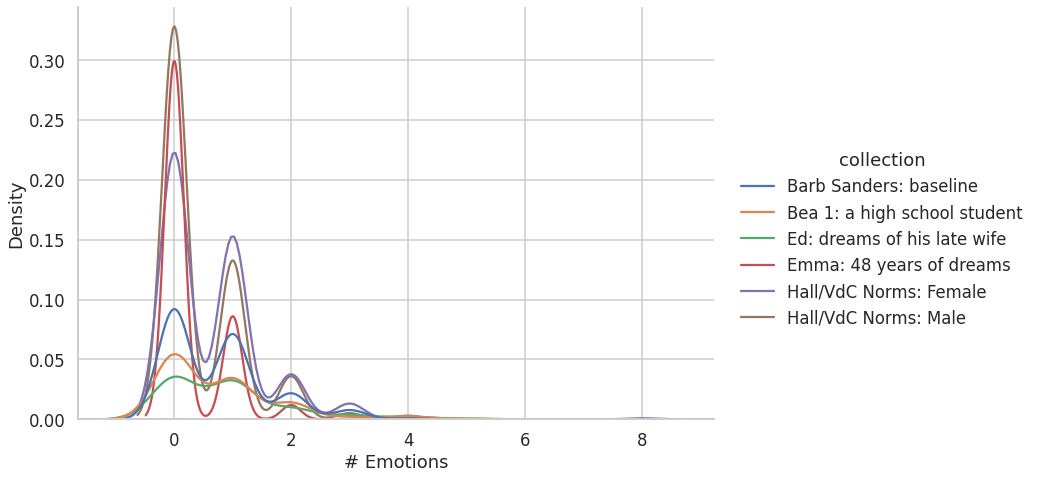

In [31]:
g = sns.displot(
    data=dream_records, x="# Emotions",
    hue="collection",
    height=7,
    aspect=1.5, 
    kind="kde",
)

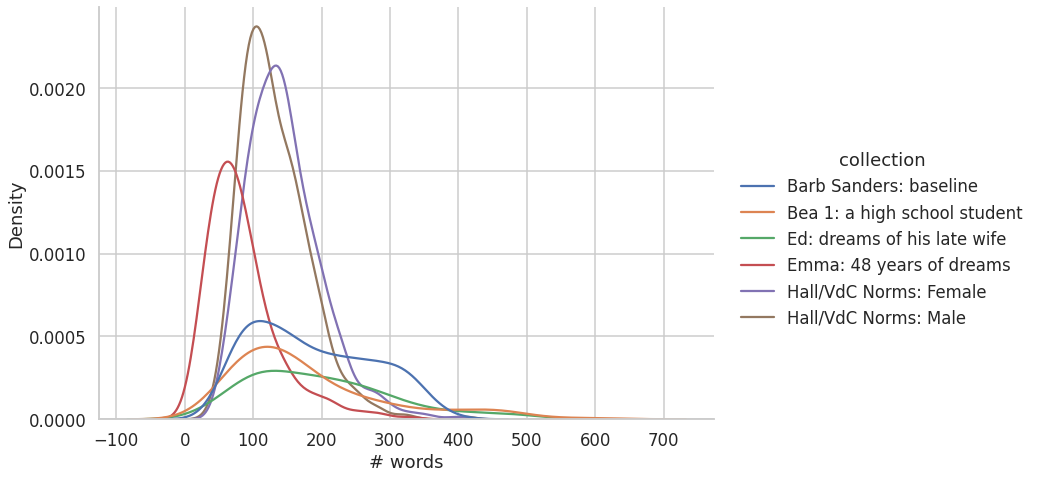

In [14]:
g = sns.displot(
    data=dream_records, 
    x="# words",
    hue="collection",
    height=7,
    aspect=1.5, 
    kind="kde",
)

###### Gender

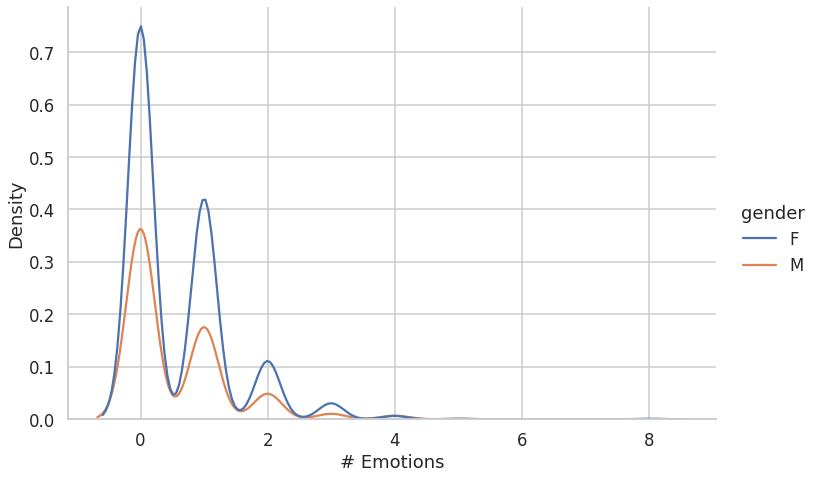

In [33]:
g = sns.displot(
    data=dream_records, 
    x="# Emotions",
    hue="gender",
    height=7,
    aspect=1.5, 
    kind="kde",
)

In [15]:
M_nLbls = dream_records[dream_records["gender"].isin(['M'])]["# Emotions"]
F_nLbls = dream_records[dream_records["gender"].isin(['F'])]["# Emotions"]

p_value = permutation_test(M_nLbls, F_nLbls,
                           method='approximate',
                           num_rounds=100000,
                           seed=seed,
                          paired=False)
                           
print("Permutation Test, # lables M vs F: pval {:.6f}".format(p_value))

Permutation Test, # lables M vs F: pval 0.356096


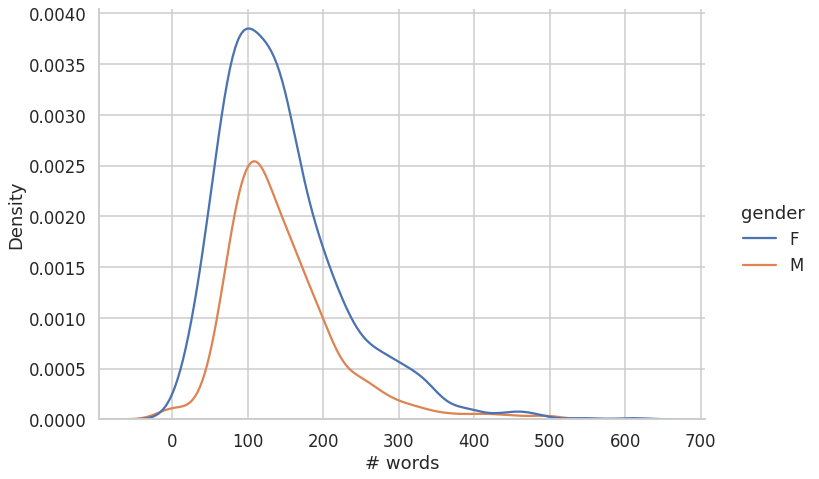

In [16]:
g = sns.displot(
    data=dream_records, x="# words",
    hue="gender",
    height=7,aspect=1.5, kind="kde",
)

In [17]:
M_nWrd = dream_records[dream_records["gender"].isin(['M'])]["# words"]
F_nWrd = dream_records[dream_records["gender"].isin(['F'])]["# words"]

p_value = permutation_test(M_nWrd, F_nWrd,
                           method='approximate',
                           num_rounds=100000,
                           seed=seed, 
                          paired=False)
print("Permutation Test, # words M vs F: pval {:.6f}".format(p_value))

Permutation Test, # words M vs F: pval 0.810352


###### Time Window

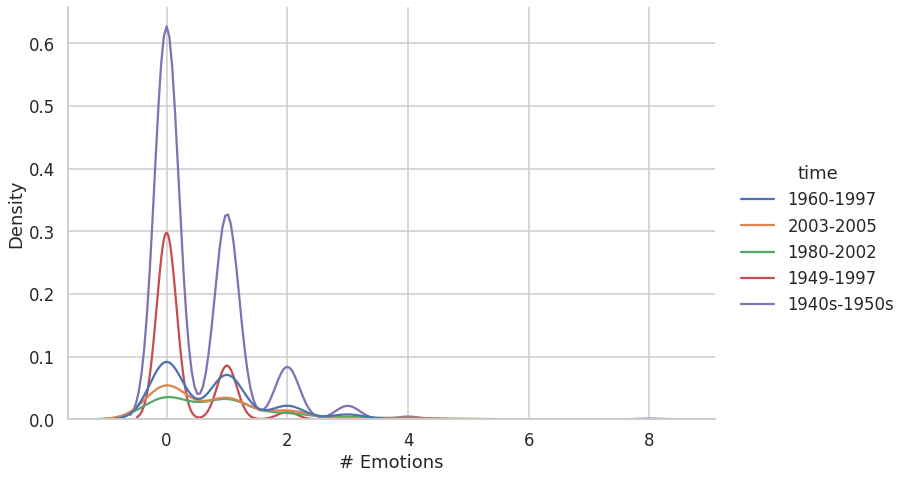

In [18]:
g = sns.displot(
    data=dream_records, 
    x="# Emotions",
    hue="time",
    height=7,
    aspect=1.5, 
    kind="kde",
)

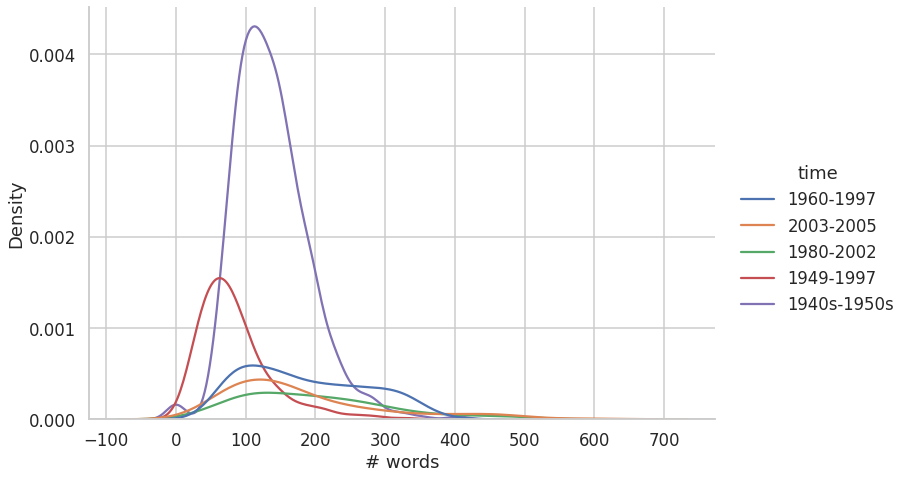

In [19]:
# # Looks like is not age...
g = sns.displot(
    data=dream_records, 
    x="# words",
    hue="time",
    height=7,
    aspect=1.5, 
    kind="kde",
)

###### Correlation # words – # Emotions

In [20]:
rho, p = spearmanr(dream_records["# words"], dream_records["# Emotions"])
print("Sperman's correlation {} - {}\n\u03C1:{:.2f}  pval:{:.5f}".format(
                                                            "# words","# labels", rho, p
                                                        )
)

Sperman's correlation # words - # labels
ρ:0.30  pval:0.00000


<Figure size 720x720 with 0 Axes>

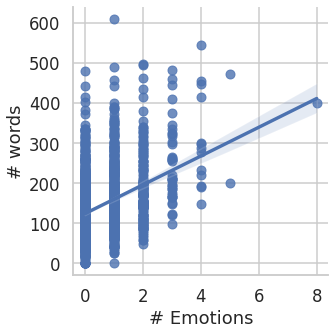

In [21]:
fig = plt.figure(figsize=(10,10))
g = sns.lmplot(
    data=dream_records, 
    y="# words", 
    x="# Emotions",
)

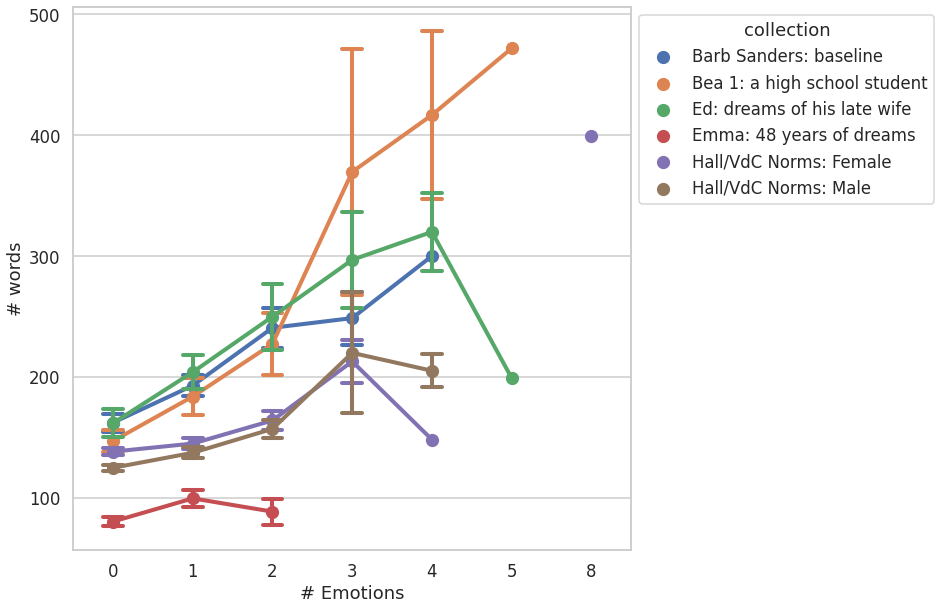

In [47]:
fig = plt.figure(figsize=(10,10))
g = sns.pointplot(
    data=dream_records, 
    y="# words", 
    x="# Emotions",
    hue="collection",
    errorbar=('se', 1),
    capsize=.25,
)

sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

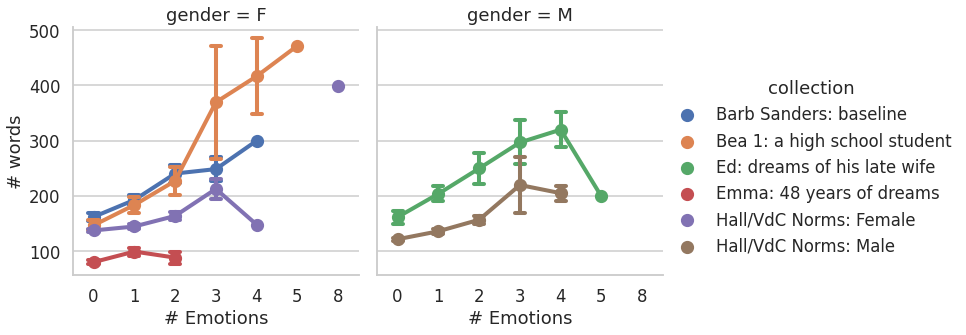

In [38]:
# fig = plt.figure(figsize=(10,10))
g = sns.catplot(
    data=dream_records, 
    y="# words", 
    x="# Emotions",
    hue="collection",
    errorbar=('se', 1),
    capsize=.25,
    kind="point",
    col="gender",
    join=True,
)

Number (\#) of Emotions and words seems to grow almost linearly untill a certain point.

## Dreams Encoding's reductions <a id='encoding'></a>

### Clustering<a id='clstr'></a>
Q1: can we visually cluseter embeddings of dreams based on things as comunity \[sane vs. ill\], people \[groups vs. single persons\]? 

Q2: If so, is the clustering, are the clusering correalted wiht (emotion) scores?  

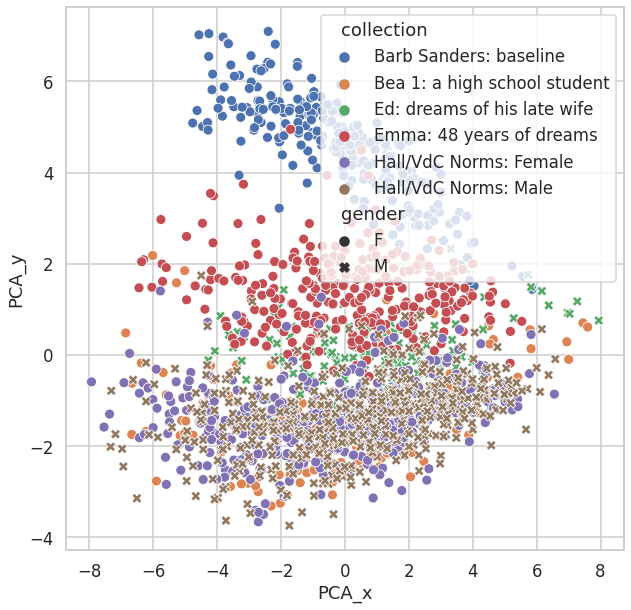

In [40]:
fig = plt.figure(figsize=(10,10))
g = sns.scatterplot(
    data=dream_records, 
    x="PCA_x", 
    y="PCA_y",
    style="gender", 
    hue="collection", 
    s=100
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)

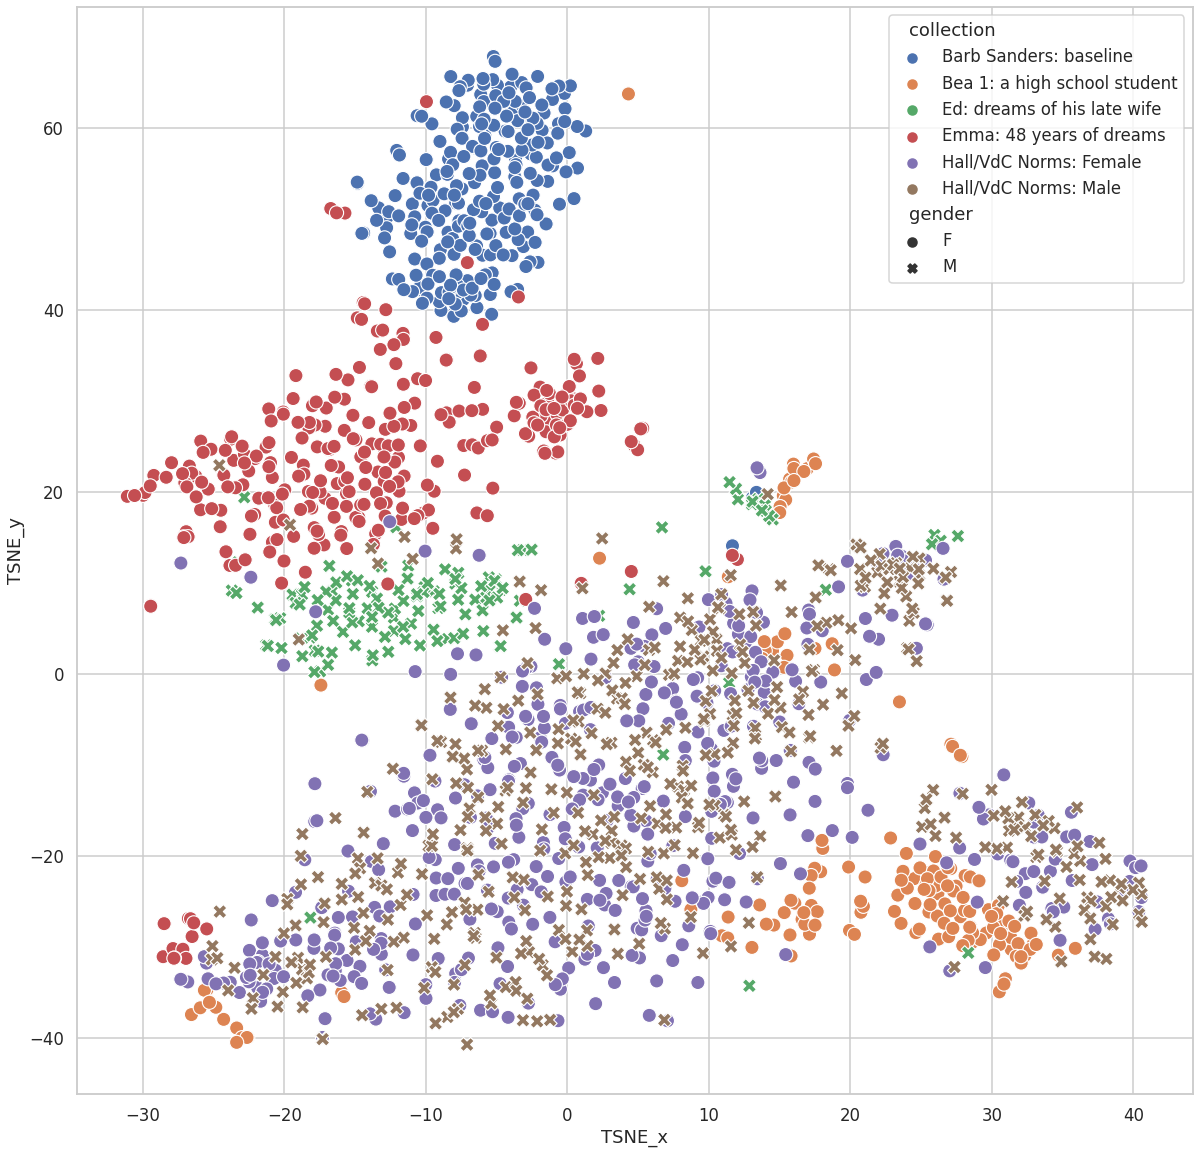

In [16]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="TSNE_x", 
    y="TSNE_y",
    style="gender",
    hue="collection", 
    s=200,
)
# plt.savefig('t-SNE_reduction.png', bbox_inches='tight', dpi=400)

#### KMean vs Variables

In [9]:
# collect the clusters
X_km        = T_encoding
n_exp_clstr = len(set(dream_records["collection"]))
kmeans_cll  = KMeans(n_clusters=n_exp_clstr, random_state=seed).fit(X_km)
kmeans_gnd  = KMeans(n_clusters=2, random_state=seed).fit(X_km)

dream_records["Kmean_Cluster_2"] = kmeans_cll.labels_
dream_records["Kmean Cluster_6"] = kmeans_gnd.labels_

In [14]:
#Store the data
dream_records.to_csv(
    "Reports_DreamerEmotions_PCACho_tsneCho_KMCluster2_KMCluster6.csv",
    index=False,
)

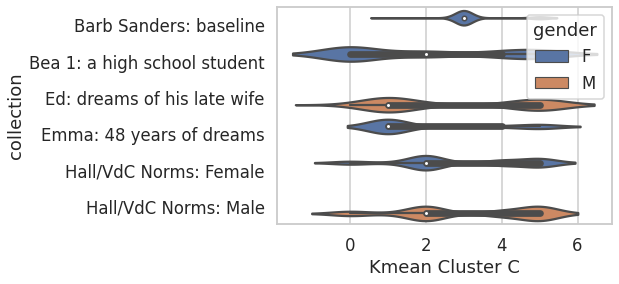

In [15]:
g = sns.violinplot(
    data=dream_records, 
    y="collection", 
    x="Kmean Cluster C", 
    hue='gender', 
    ci="se"
)

<AxesSubplot:xlabel='Kmean Cluster C', ylabel='# words'>

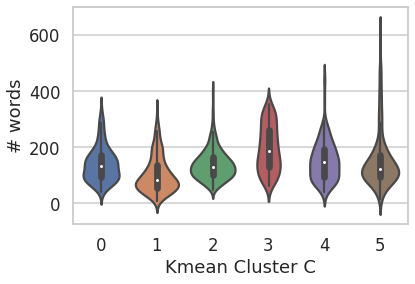

In [16]:
sns.violinplot(
    data=dream_records, 
    x="Kmean Cluster C", 
    y="# words",
    ci="se",
)

<AxesSubplot:xlabel='Kmean Cluster G', ylabel='# words'>

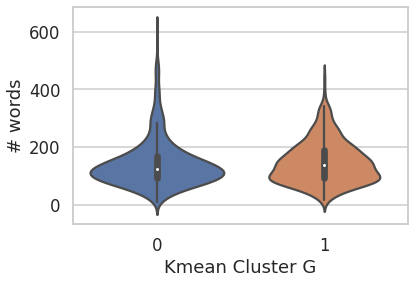

In [58]:
sns.violinplot(
    data=dream_records, 
    x="Kmean Cluster G", 
    y="# words",
    ci="se",
)

<AxesSubplot:xlabel='Kmean Cluster C', ylabel='# Emotions'>

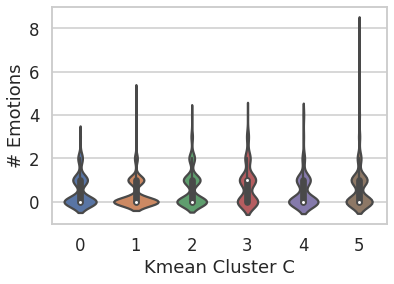

In [59]:
sns.violinplot(
    data=dream_records, 
    x="Kmean Cluster C", 
    y="# Emotions",
    ci="se",
)

<AxesSubplot:xlabel='Kmean Cluster G', ylabel='# Emotions'>

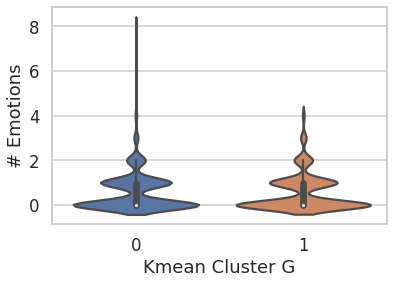

In [60]:
sns.violinplot(
    data=dream_records, 
    x="Kmean Cluster G", 
    y="# Emotions",
    ci="se",
)

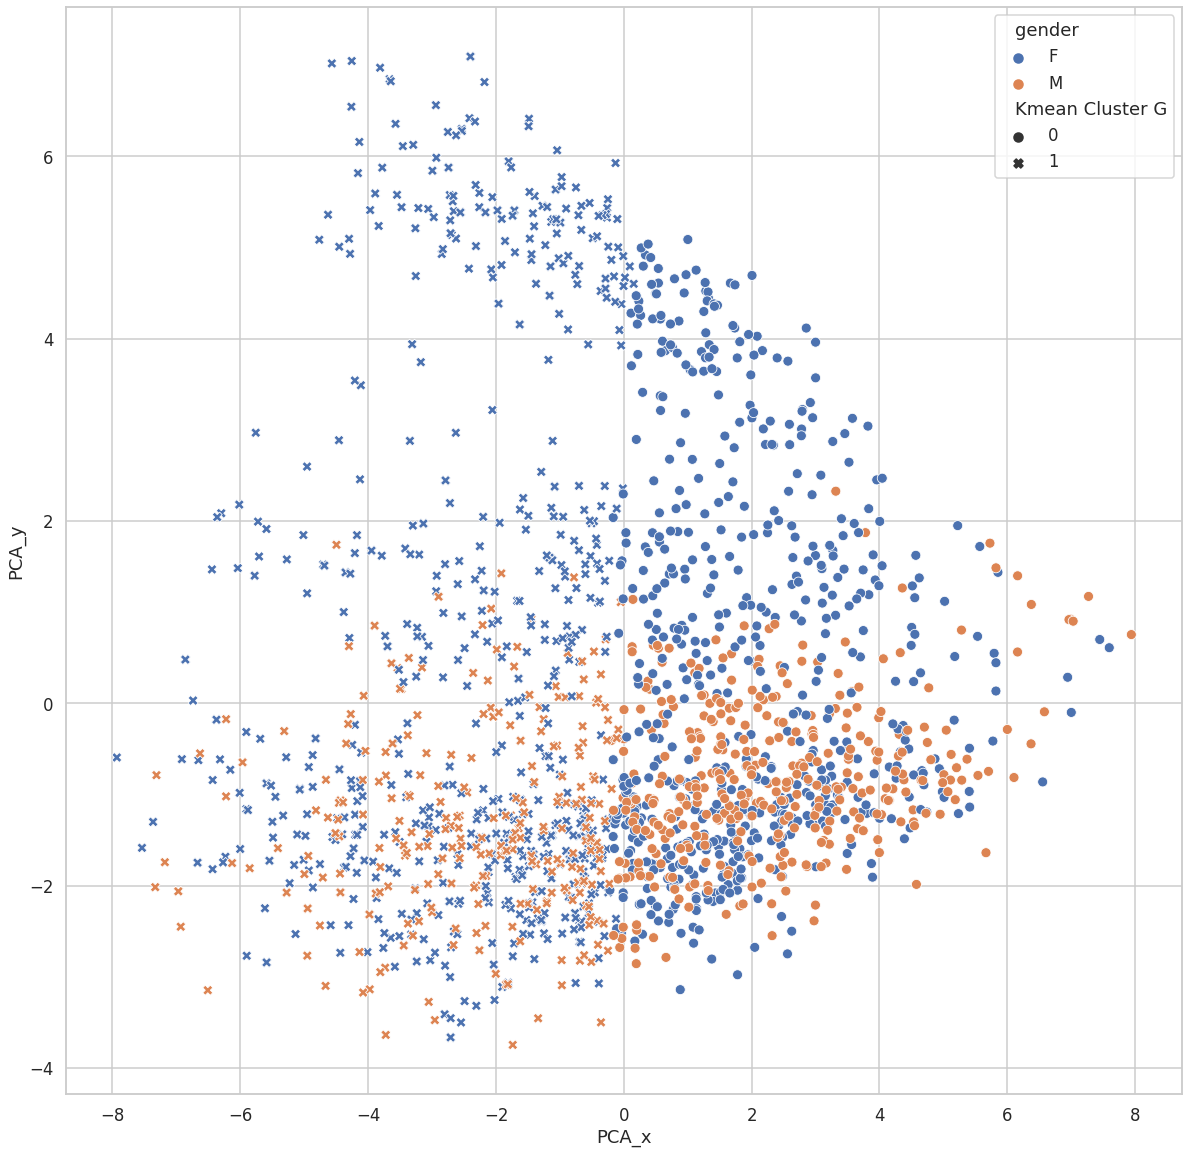

In [13]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="PCA_x", 
    y="PCA_y",
    style="Kmean Cluster G", 
    hue="gender", 
    s=100,
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)

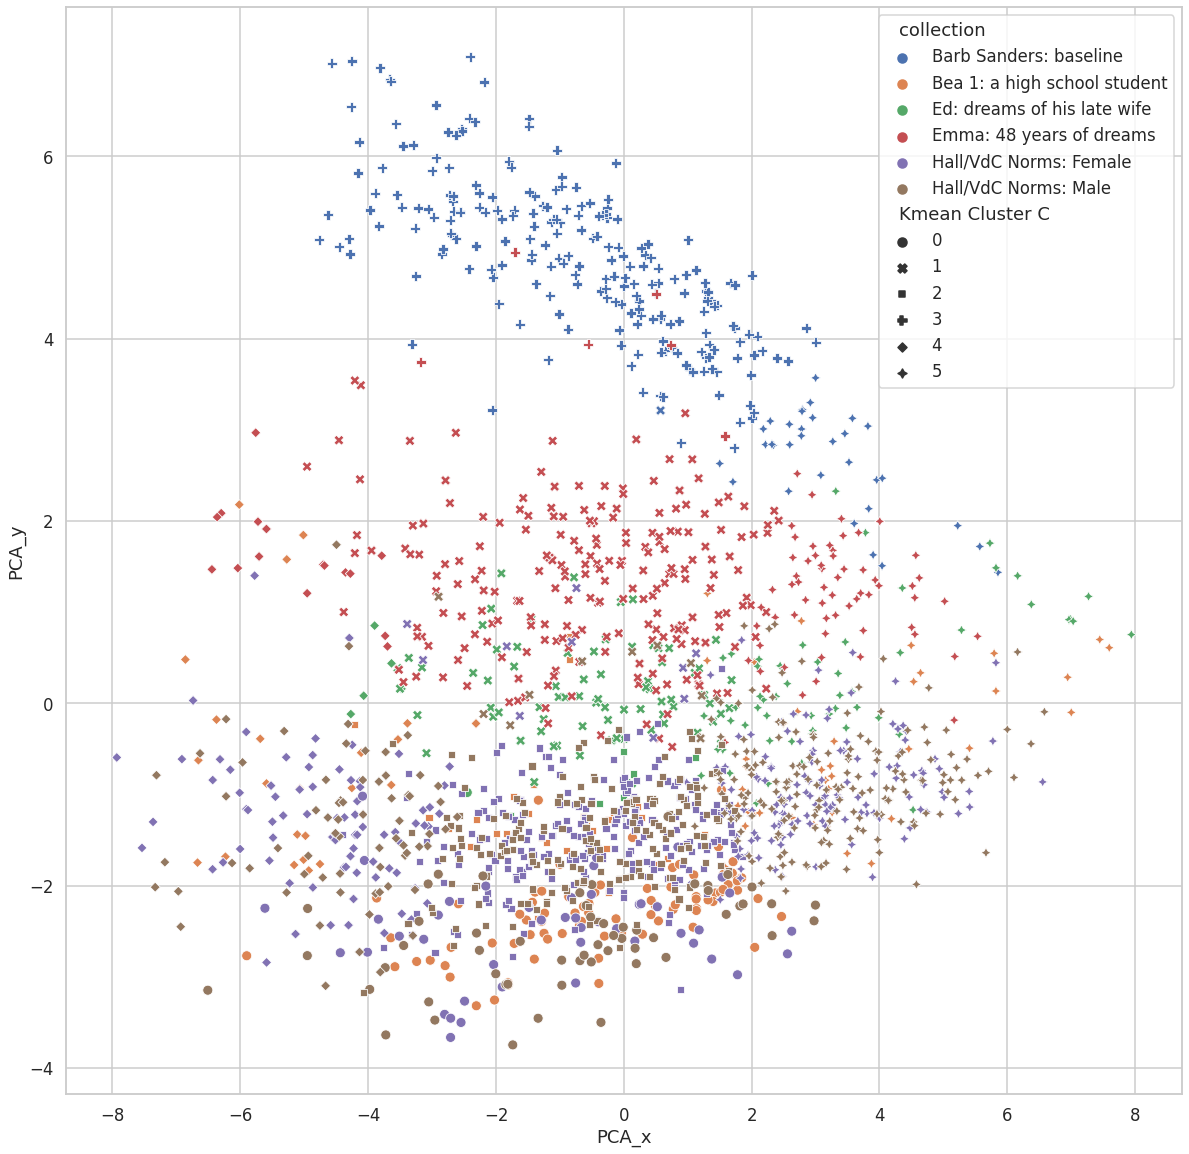

In [14]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="PCA_x", 
    y="PCA_y",
    style="Kmean Cluster C",
    hue="collection", 
    s=100,
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)

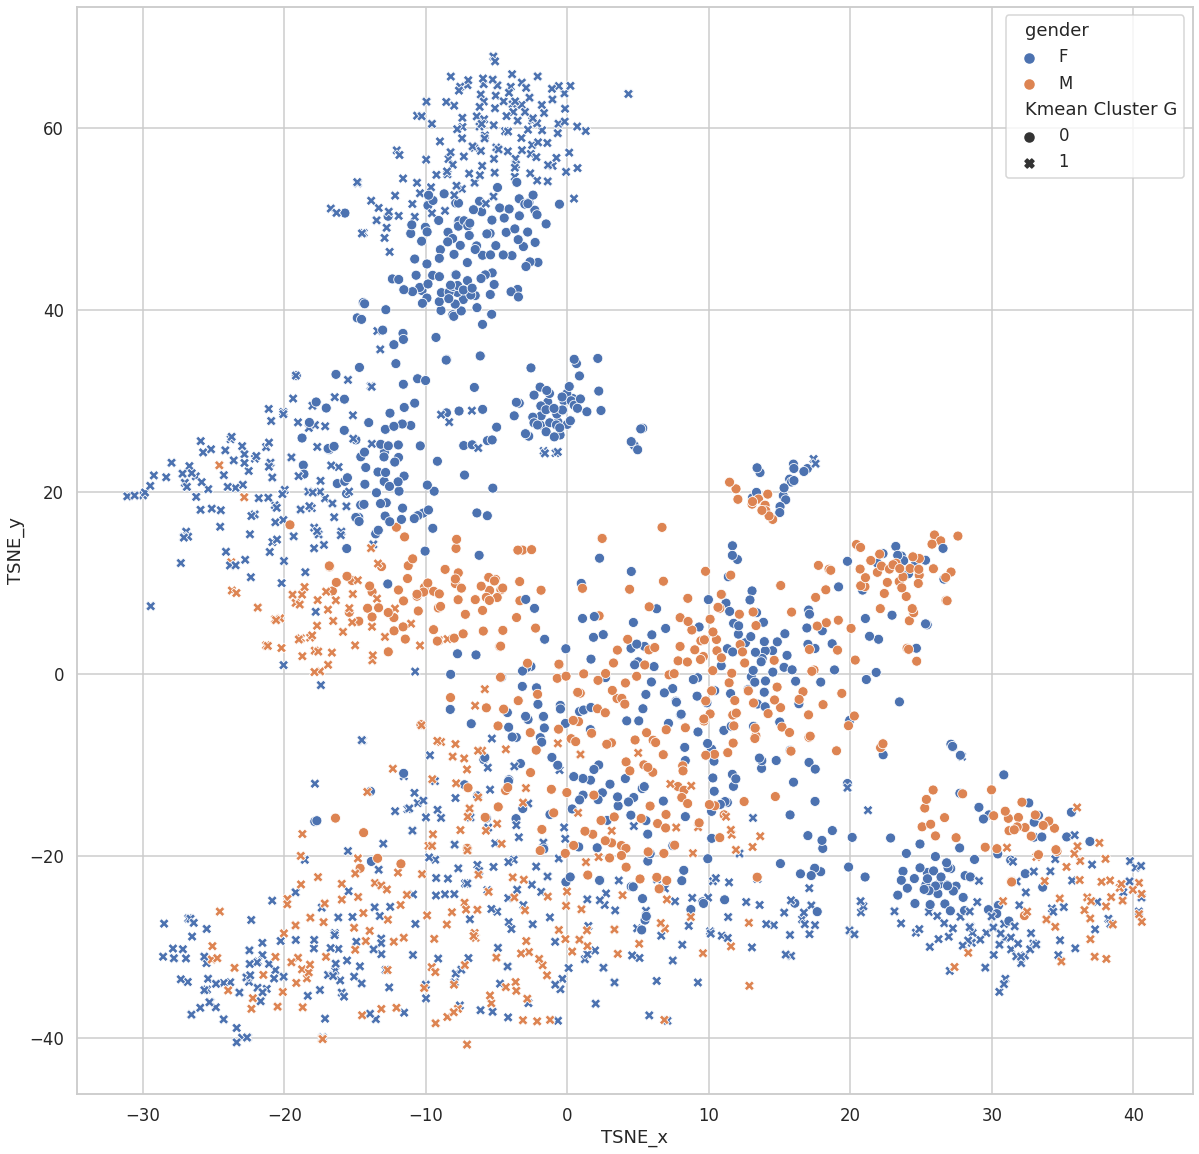

In [15]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, 
    x="TSNE_x", 
    y="TSNE_y",
    style="Kmean Cluster G", 
    hue="gender", 
    s=100,
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)

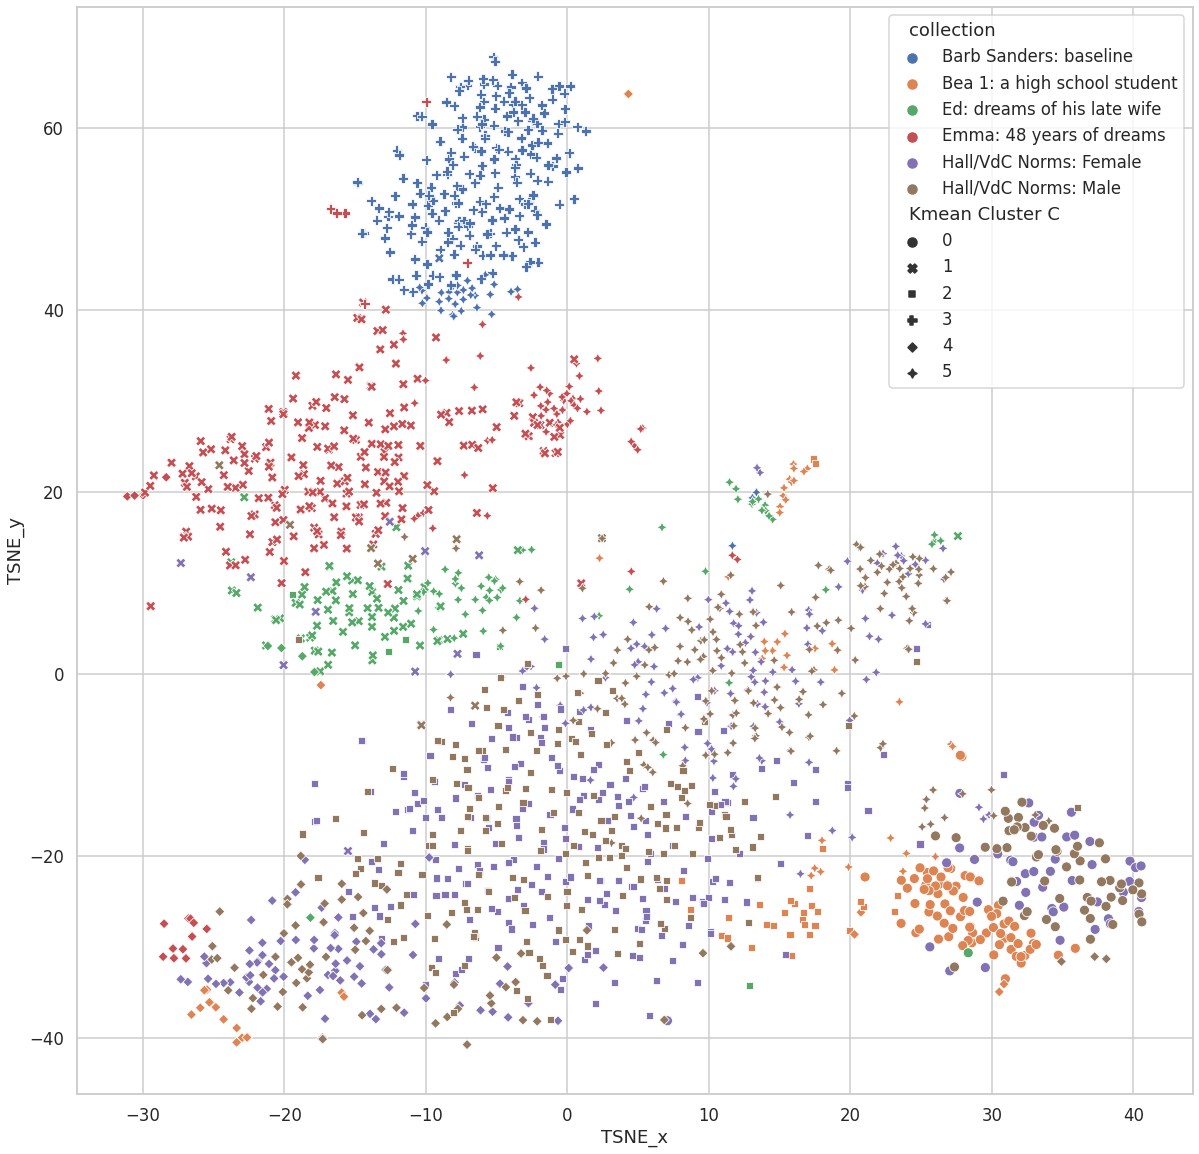

In [16]:
fig = plt.figure(figsize=(20,20))
g = sns.scatterplot(
    data=dream_records, x="TSNE_x", y="TSNE_y",
    style="Kmean Cluster C", hue="collection", s=100
)
# plt.savefig('PCA_reduction.png', bbox_inches='tight', dpi=400)